<a href="https://colab.research.google.com/github/Gopikasri-lab/projects/blob/main/Customer_Churn_predictions_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder


In [2]:
# Load dataset
df = pd.read_excel("E Commerce Dataset.xlsx", sheet_name="E Comm")

# Drop CustomerID (not needed for prediction)
df.drop(columns=["CustomerID"], inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, columns=["PreferredLoginDevice", "PreferredPaymentMode",
                                 "Gender", "PreferedOrderCat", "MaritalStatus"], drop_first=True)

# Convert target column to numeric
le = LabelEncoder()
df["Churn"] = le.fit_transform(df["Churn"])

# Fill missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Normalize numerical features
scaler = MinMaxScaler()
num_cols = ["Tenure", "WarehouseToHome", "HourSpendOnApp", "OrderAmountHikeFromlastYear",
            "CouponUsed", "OrderCount", "DaySinceLastOrder", "CashbackAmount"]
df[num_cols] = scaler.fit_transform(df[num_cols])


In [4]:
from imblearn.over_sampling import SMOTE

In [5]:
SEQ_LENGTH = 10  # Look back at 10 past transactions

def create_sequences(data, target_col, seq_length=SEQ_LENGTH):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].drop(columns=[target_col]).values)
        Y.append(data.iloc[i+seq_length][target_col])  # Only last value as label
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32).reshape(-1, 1)  # Ensure Y is 2D

# Prepare sequences
X, Y = create_sequences(df, target_col="Churn")
SEQ_LENGTH = 10  # Look back at 10 past transactions

def create_sequences(data, target_col, seq_length=SEQ_LENGTH):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].drop(columns=[target_col]).values)
        Y.append(data.iloc[i+seq_length][target_col])  # Only last value as label
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32).reshape(-1, 1)  # Ensure Y is 2D


# Reshape X for SMOTE
X_flat = X.reshape(X.shape[0], -1)

# Apply SMOTE (Oversampling Churn Cases)
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_flat, Y.ravel())

# Reshape X back to (samples, seq_length, features)
X_resampled = X_resampled.reshape(-1, SEQ_LENGTH, X.shape[2])
Y_resampled = Y_resampled.reshape(-1, 1)

# Train-test split again
x_train, x_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, shuffle=True)

# Print shapes
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)




x_train shape: (7491, 10, 29) y_train shape: (7491, 1)
x_test shape: (1873, 10, 29) y_test shape: (1873, 1)


In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights to balance training
class_weights = compute_class_weight("balanced", classes=np.unique(Y_resampled), y=Y_resampled.ravel())
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)


Class Weights: {0: 1.0, 1: 1.0}


In [8]:
# Define LSTM Model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 128)             │          80,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,361 (513.13 KB)

 Trainable params: 131,361 (513.13 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.5206 - loss: 0.6926 - val_accuracy: 0.6257 - val_loss: 0.6511
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.6189 - loss: 0.6474 - val_accuracy: 0.7069 - val_loss: 0.5518
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7285 - loss: 0.5267 - val_accuracy: 0.7736 - val_loss: 0.4571
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8023 - loss: 0.4052 - val_accuracy: 0.8233 - val_loss: 0.3592
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8364 - loss: 0.3315 - val_accuracy: 0.8537 - val_loss: 0.3117
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.8887 - loss: 0.2517 - val_accuracy: 0.8783 - val_loss: 0.2529
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9152 - loss: 0.1978 - val_accuracy: 0.9204 - val_loss: 0.2004
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9246 - loss: 0.1759 - val_ac

In [11]:
# Make predictions
y_pred = (model.predict(x_test) > 0.3).astype(int)

# Evaluate Model
from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Test Accuracy: 0.9353977576081153
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       942
         1.0       0.97      0.90      0.93       931

    accuracy                           0.94      1873
   macro avg       0.94      0.94      0.94      1873
weighted avg       0.94      0.94      0.94      1873



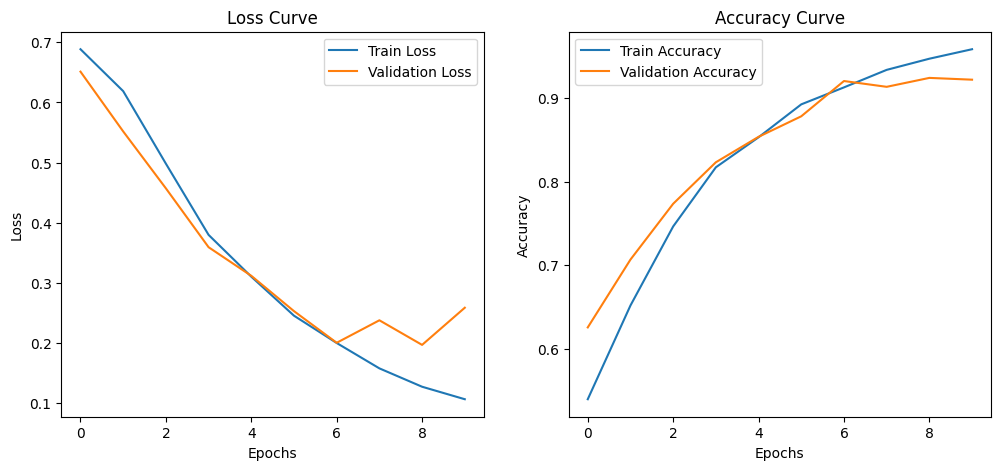

In [12]:
import matplotlib.pyplot as plt

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


In [13]:
# Save Model
model.save("customer_churn_lstm.h5")

# Load Model for Future Predictions
from tensorflow.keras.models import load_model

loaded_model = load_model("customer_churn_lstm.h5")

# Verify by making a test prediction
sample_input = x_test[:1]  # Select one sample
prediction = loaded_model.predict(sample_input)
print("Churn Probability:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
Churn Probability: [[3.2518867e-34]]
